In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [59]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp['Day'] = i
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 10), (3888, 8))

In [60]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [61]:
min = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].max()

In [62]:
for i, col in enumerate(['Day','Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [8]:
Day0 = df_train.iloc[:, :-2]
Day  = df_train.iloc[:, 1:-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

df_test0 = df_test.copy()
df_test = df_test.iloc[:, 1:]

In [9]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [10]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [13]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 2s 3ms/step - loss: 367.3883 - val_loss: 178.8931
Epoch 2/100
615/615 [==============================] - 1s 2ms/step - loss: 171.6994 - val_loss: 158.0998
Epoch 3/100
615/615 [==============================] - 1s 2ms/step - loss: 153.0226 - val_loss: 150.6760
Epoch 4/100
615/615 [==============================] - 1s 2ms/step - loss: 154.1150 - val_loss: 148.6838
Epoch 5/100
615/615 [==============================] - 1s 2ms/step - loss: 148.2095 - val_loss: 147.8098
Epoch 6/100
615/615 [==============================] - 1s 2ms/step - loss: 150.1184 - val_loss: 149.6413
Epoch 7/100
615/615 [==============================] - 1s 2ms/step - loss: 149.8693 - val_loss: 146.2519
Epoch 8/100
615/615 [==============================] - 1s 2ms/step - loss: 142.4574 - val_loss: 147.2933
Epoch 9/100
615/615 [==============================] - 1s 2ms/step - loss: 148.2808 - val_loss: 146.2809
Epoch 10/100
615/615 [==============================] -

136.9035186767578

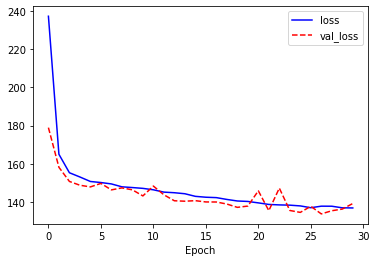

In [14]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [15]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4466 - val_loss: 1.5857
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4015 - val_loss: 1.5911
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3885 - val_loss: 1.5875
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3851 - val_loss: 1.5817
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3950 - val_loss: 1.5888
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3919 - val_loss: 1.5936
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3963 - val_loss: 1.5751
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4032 - val_loss: 1.5890
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3972 - val_loss: 1.5817
Epoch 10/100
820/820 [==============================] - 1s 1ms/step - loss: 1.4083 - val_lo

820/820 [==============================] - 1s 1ms/step - loss: 2.7447 - val_loss: 3.1620
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 2.6437 - val_loss: 2.9995
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6233 - val_loss: 3.0241
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6223 - val_loss: 3.0258
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6248 - val_loss: 3.0458
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3431 - val_loss: 2.6631
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3206 - val_loss: 2.6859
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3236 - val_loss: 2.6837
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3227 - val_loss: 2.6837
Epoch 00004: early stopping
Epoch 1/100
820/820

820/820 [==============================] - 2s 2ms/step - loss: 0.7854 - val_loss: 0.8803
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7706 - val_loss: 0.9529
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7775 - val_loss: 0.9230
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7760 - val_loss: 0.8663
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 0.7671 - val_loss: 0.8712
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7696 - val_loss: 0.8625
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7781 - val_loss: 0.8868
Epoch 8/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7832 - val_loss: 0.8882
Epoch 9/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7624 - val_loss: 0.8661
Epoch 00009: early stopping


(3888, 18)

In [16]:
from lightgbm import LGBMRegressor

In [17]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34889
Early stopping, best iteration is:
[418]	valid_0's quantile: 1.34812
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14466
[1000]	valid_0's quantile: 2.13764
[1500]	valid_0's quantile: 2.13582
[2000]	valid_0's quantile: 2.1334
Early stopping, best iteration is:
[1749]	valid_0's quantile: 2.13312
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.53565
[1000]	valid_0's quantile: 2.50726
[1500]	valid_0's quantile: 2.49216
Early stopping, best iteration is:
[1604]	valid_0's quantile: 2.48959
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66191
[1000]	valid_0's quantile: 2.62846
[1500]	valid_0's quantile: 2.61266
[2000]	valid_0's quantile: 2.6059
[2500]	valid_0's quantile: 2.59923
[3000]	valid_0's quantile: 2.59644
Early stopping, best iteration is:
[2707]	v

In [64]:
df_train['RANK'] = df_train.TARGET.rank(ascending=True, method='dense')
df_test['RANK'] = df_test.TARGET.rank(ascending=True, method='dense')
df_train.columns = ['Day', 'Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'RANK', 'Target1','Target2']

In [65]:
min = df_train['RANK'].min()
max  = df_train['RANK'].max()

df_train['RANK'] = (df_train['RANK'] - min) / (max - min)
df_test['RANK'] = (df_test['RANK'] - min) / (max - min)

In [47]:
DayR = df_train.iloc[:, 1:-2]
df_testR = df_test.copy()
df_test = df_test.iloc[:,:-1]

,Hour,TARGET,DHI,DNI,WS,RH,T
288,0.000000,0.0,0.0,0.0,0.229161,0.793529,0.300000
289,0.000000,0.0,0.0,0.0,0.250240,0.800130,0.298148
290,0.043478,0.0,0.0,0.0,0.270238,0.782599,0.296296
291,0.043478,0.0,0.0,0.0,0.250240,0.782599,0.296296
292,0.086957,0.0,0.0,0.0,0.250240,0.753273,0.296296
...,...,...,...,...,...,...,...
331,0.913043,0.0,0.0,0.0,0.229161,0.603398,0.605556
332,0.956522,0.0,0.0,0.0,0.206877,0.619305,0.594444
333,0.956522,0.0,0.0,0.0,0.206877,0.633157,0.588889
334,1.000000,0.0,0.0,0.0,0.183241,0.649821,0.581481


In [37]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(DayR).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_testR).reshape(3888, 1, 8)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0158 - val_loss: 0.0104
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
820/820 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 4.3815e-04
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 10/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0016 

820/820 [==============================] - 2s 2ms/step - loss: 7.5850e-04 - val_loss: 3.1290e-04
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 7.3683e-04
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 8.6891e-04 - val_loss: 0.0017
Epoch 11/100
820/820 [==============================] - 2s 2ms/step - loss: 9.5534e-04 - val_loss: 1.8687e-04
Epoch 12/100
820/820 [==============================] - 2s 2ms/step - loss: 8.3721e-04 - val_loss: 0.0014
Epoch 00012: early stopping
0.8
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 7.8021e-04 - val_loss: 6.3240e-04
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 6.7350e-04 - val_loss: 2.5219e-04
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 8.6851e-04 - val_loss: 2.2655e-04
Epoch 5/100
820/

(3888, 9)

In [48]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8.shape

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4552 - val_loss: 1.6473
Epoch 2/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4441 - val_loss: 1.6423
Epoch 3/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4338 - val_loss: 1.6407
Epoch 4/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4259 - val_loss: 1.6400
Epoch 5/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4428 - val_loss: 1.6394
Epoch 6/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4357 - val_loss: 1.6447
Epoch 7/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4439 - val_loss: 1.6453
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4508 - val_loss: 1.6393
Epoch 9/100
820/820 [==============================] - 1s 2ms/step - loss: 1.4500 - val_loss: 1.6382
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4589 - va

820/820 [==============================] - 2s 2ms/step - loss: 2.4102 - val_loss: 2.7605
Epoch 14/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3972 - val_loss: 2.8069
Epoch 00014: early stopping
0.7
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9677 - val_loss: 2.2151
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9689 - val_loss: 2.2311
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9598 - val_loss: 2.2480
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9681 - val_loss: 2.2407
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9695 - val_loss: 2.2074
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9439 - val_loss: 2.2250
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.9707 - val_loss: 2.2421
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - l

(3888, 9)

In [51]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(DayR).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_testR).reshape(3888, 1, 8)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7.shape

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 0.0115 - val_loss: 0.0014
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0018 - val_loss: 6.5671e-04
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0014 - val_loss: 8.5856e-04
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0013 - val_loss: 6.0549e-04
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss:

0.4
Epoch 1/100
820/820 [==============================] - 6s 5ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 9.3030e-04 - val_loss: 6.3936e-04
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0010 - val_loss: 8.5122e-04
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 9.9084e-04 - val_loss: 6.7060e-04
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0012 - val_loss: 7.5824e-04
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 8.1538e-04 - val_loss: 4.8565e-04
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 8.7258e-04 - val_loss: 9.5887e-04
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 9.3458e-04 - val_loss: 0.0012
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 8.5593e-04 - val_loss: 3.2825e-04
Epoch 10/100
820/820 [=============

820/820 [==============================] - 6s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 8.1229e-04 - val_loss: 8.2601e-04
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 7.3976e-04 - val_loss: 9.6856e-04
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 8.9510e-04 - val_loss: 6.1086e-04
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 8.2559e-04 - val_loss: 6.1910e-04
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 9.7276e-04 - val_loss: 9.6763e-04
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 9.0713e-04 - val_loss: 3.6537e-04
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 8.7374e-04 - val_loss: 0.0013
Epoch 9/100
820/820 [==============================] - 4s 5ms/step - loss: 8.4215e-04 - val_loss: 2.9794e-04
Epoch 10/100
820/820 [=====================

(3888, 9)

In [52]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8.shape

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0158 - val_loss: 0.0162
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0145 - val_loss: 0.0160
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0144 - val_loss: 0.0163
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0145 - val_loss: 0.0163
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0144 - val_loss: 0.0161
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0142 - val_loss: 0.0162
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0142 - val_loss: 0.0161
Epoch 00007: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 7s 5ms/step - loss: 0.0229 - val_loss: 0.0261
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0225 - val_loss: 0.0258
Epoch 3/100
820/820 [==============================] - 

820/820 [==============================] - 6s 4ms/step - loss: 0.0277 - val_loss: 0.0310
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0273 - val_loss: 0.0310
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0273 - val_loss: 0.0314
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0272 - val_loss: 0.0312
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0275 - val_loss: 0.0315
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0276 - val_loss: 0.0314
Epoch 7/100
820/820 [==============================] - 4s 4ms/step - loss: 0.0277 - val_loss: 0.0310
Epoch 00007: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 7s 5ms/step - loss: 0.0268 - val_loss: 0.0301
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0264 - val_loss: 0.0297
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - lo

0.8
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0149 - val_loss: 0.0167
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0147 - val_loss: 0.0169
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0147 - val_loss: 0.0174
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0149 - val_loss: 0.0174
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0149 - val_loss: 0.0164
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0149 - val_loss: 0.0164
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0149 - val_loss: 0.0168
Epoch 9/100
820/820 [==============================] - 4s 4ms/step - loss: 0.0146 - val_loss: 0.0169
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0149 - va

(3888, 9)

In [66]:
df_test # Day	Hour	TARGET	DHI	DNI	WS	RH	T	RANK

,Day,Hour,TARGET,DHI,DNI,WS,RH,T,RANK
288,0.0,0.0,0.0,0.0,0.0,0.847997,80.92,-2.8,0.0
289,0.0,0.0,0.0,0.0,0.0,0.925999,81.53,-2.9,0.0
290,0.0,1.0,0.0,0.0,0.0,1.000000,79.91,-3.0,0.0
291,0.0,1.0,0.0,0.0,0.0,0.925999,79.91,-3.0,0.0
292,0.0,2.0,0.0,0.0,0.0,0.925999,77.20,-3.0,0.0
...,...,...,...,...,...,...,...,...,...
331,80.0,21.0,0.0,0.0,0.0,0.847997,63.35,13.7,0.0
332,80.0,22.0,0.0,0.0,0.0,0.765535,64.82,13.1,0.0
333,80.0,22.0,0.0,0.0,0.0,0.765535,66.10,12.8,0.0
334,80.0,23.0,0.0,0.0,0.0,0.678072,67.64,12.4,0.0


In [67]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 9]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(df_train.iloc[:,:-2]).reshape(52464, 1, 9), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test).reshape(3888, 1, 9)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7.shape

0.1
Epoch 1/100
820/820 [==============================] - 5s 4ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0141 - val_loss: 0.0161
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0141 - val_loss: 0.0160
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0141 - val_loss: 0.0166
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0141 - val_loss: 0.0167
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0141 - val_loss: 0.0160
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0142 - va

0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.0268 - val_loss: 0.0299
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0265 - val_loss: 0.0297
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0264 - val_loss: 0.0297
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0264 - val_loss: 0.0307
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0267 - val_loss: 0.0301
Epoch 00005: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 7s 4ms/step - loss: 0.0242 - val_loss: 0.0272
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0239 - val_loss: 0.0267
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0238 - val_loss: 0.0270
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0237 - val_loss: 0.0280
Epoch 5/100
820/820 [==============================] - 

Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 00006: early stopping


(3888, 9)

In [70]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day0).reshape(52464, 1, 8), np.array(Day8).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test0).reshape(3888, 1, 8)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)

0.1
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 1.5666 - val_loss: 1.6512
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4552 - val_loss: 1.6533
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4321 - val_loss: 1.6618
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4194 - val_loss: 1.6383
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4290 - val_loss: 1.6355
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4154 - val_loss: 1.6529
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4245 - val_loss: 1.6651
Epoch 8/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4288 - val_loss: 1.6575
Epoch 00008: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.4301 - val_loss: 2.7396
Epoch 2/100
820/820 [==============================] - 

820/820 [==============================] - 3s 4ms/step - loss: 2.9429 - val_loss: 3.3189
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.9291 - val_loss: 3.2956
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 2.9350 - val_loss: 3.3381
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.9280 - val_loss: 3.3008
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 2.9117 - val_loss: 3.3096
Epoch 00006: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.8768 - val_loss: 3.1920
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 2.8411 - val_loss: 3.2063
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.8314 - val_loss: 3.2090
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 2.8359 - val_loss: 3.1907
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - lo

820/820 [==============================] - 6s 5ms/step - loss: 1.5076 - val_loss: 1.7030
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4917 - val_loss: 1.6782
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4865 - val_loss: 1.7772
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4899 - val_loss: 1.6626
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4845 - val_loss: 1.6799
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4618 - val_loss: 1.6526
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4919 - val_loss: 1.6651
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4813 - val_loss: 1.6985
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4646 - val_loss: 1.6496
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4756 - val_loss: 1.6860
E

In [72]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_1.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [73]:
res_0 = pd.DataFrame()
res_0res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [74]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [ ]:
res_0[:48]#.to_csv('0.csv', index=False)

In [75]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [76]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [77]:
submission.to_csv('./submission/submission_20210122-3.csv', index=False)